# Chapter 6. Machine Learning

Ildar Rakhmatulin ildarr2016@gmail.com

## Import libraries
To install libraries in Python, you can use a package manager like pip, which comes pre-installed with most Python distributions.



In [10]:

#from peakdetect import peakdetect
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
import scipy.interpolate as spi

import math
import scipy.fftpack

from scipy.fft import fftshift
from matplotlib import mlab
from scipy.linalg import eig
from scipy.signal import butter, filtfilt, hilbert



from sklearn.preprocessing import StandardScaler


from sklearn.cluster import KMeans

## Import Dataset

Load dataset
https://github.com/Ildaron/ironbci  
The following dataset structure is used  


ch1	ch2	ch3	ch4	ch5	ch6	ch7	ch8  
..    ..    ..  ..  ..  ..  ..  ..    
..    ..    ..  ..  ..  ..  ..  ..  

          ch1     ch2      ch3      ch4      ch5     ch6      ch7      ch8
0     23899.1  2951.1  36442.2  38418.6  12414.9  3759.5  31001.4  52775.3
1     23917.7  3048.0  36463.8  38344.3  12448.1  3726.3  31032.4  52223.4
2     23984.9  3148.2  36525.1  39002.6  12520.4  3601.3  31103.2  53175.1
3     24016.8  3183.3  36551.5  39602.8  12548.5  3473.0  31133.2  54514.6
4     23960.3  3061.0  36494.8  39256.9  12475.6  3549.7  31061.9  54321.3
...       ...     ...      ...      ...      ...     ...      ...      ...
7115  23896.6  3893.1  37567.5  38276.6  11183.1  4515.5  31611.9  48532.8
7116  23850.2  3780.5  37514.3  38075.4  11119.7  4572.2  31551.9  48566.2
7117  23766.2  3644.2  37432.3  37477.1  11029.8  4755.0  31464.2  47165.5
7118  23768.4  3709.8  37443.6  37362.9  11048.4  4738.0  31481.5  46410.0
7119  23841.3  3830.5  37514.9  37800.0  11130.5  4623.2  31560.6  47139.6

[7120 rows x 8 columns]


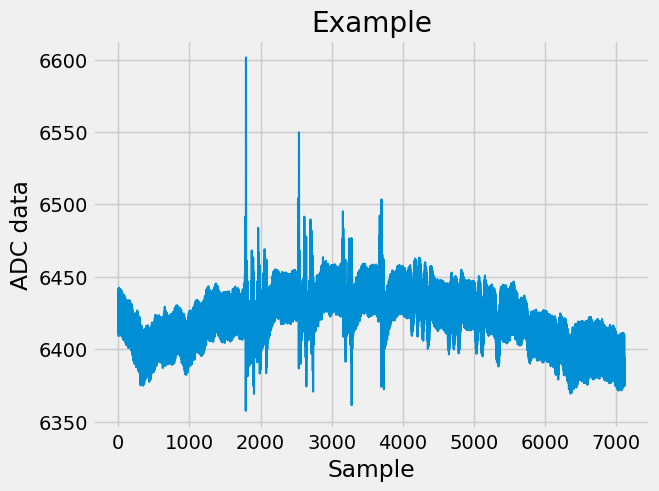

In [11]:
#len_data = 1169
#value_data = 27

dataset_y_row = pd.read_excel("https://github.com/rklymentiev/EEG_course/raw/master/dataset/dataset.xlsx")
print(dataset_y_row)
dataset_y = dataset_y_row.transpose()

dataset_one_ch = dataset_y.iloc[0]
dataset_one_ch = round(1000000*4.5*(dataset_one_ch/16777215),2)

plt.plot(dataset_one_ch)
plt.title("Example")
plt.ylabel('ADC data')
plt.xlabel('Sample')
plt.show()

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Band Pass Filter


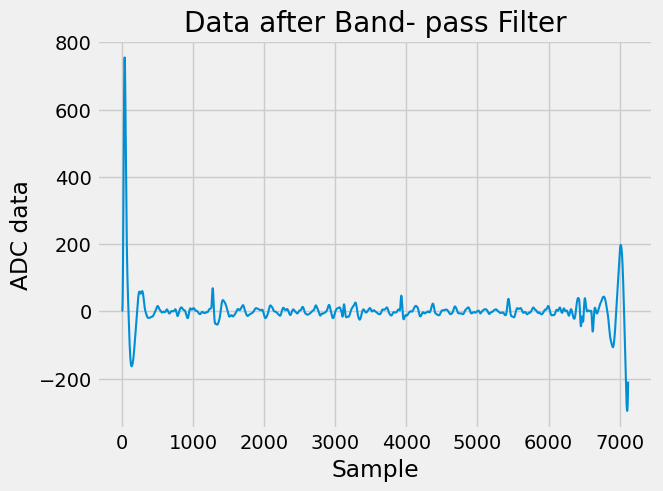

In [13]:
data_after_band_pass_filter = dataset_y

def butter_highpass(cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a
def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff_high, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
def butter_lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

fps = 250
cutoff_high=1
cutoff_low=5
x=[]
for a in range(0,8,1):
    filtered_sine_high = butter_highpass_filter(dataset_y.iloc[a], cutoff_high, fps)
    filtered_high_pass= butter_lowpass_filter(filtered_sine_high, cutoff_low, fps)
    data_after_band_pass_filter.iloc[a] = filtered_high_pass
    test = filtered_high_pass

plt.plot(filtered_high_pass)
plt.title("Data after Band- pass Filter")
plt.ylabel('ADC data')
plt.xlabel('Sample')
plt.show()

## Preprocessing

MinMaxScaler and StandardScaler are preprocessing techniques used in machine learning to scale and normalize input features.

MinMaxScaler: MinMaxScaler scales features to a specific range, typically between 0 and 1. It subtracts the minimum value of the feature and then divides by the range (maximum minus minimum). This is useful when features have varying scales, ensuring they are all within the same numerical range and preventing one feature from dominating others during model training.

StandardScaler: StandardScaler standardizes features by subtracting the mean and dividing by the standard deviation. This transforms the features to have a mean of 0 and a standard deviation of 1. StandardScaler is effective when features exhibit different distributions and variances, as it centers the data around the mean and brings it to a consistent scale.

In summary, MinMaxScaler is used when you want to scale features within a specific range, while StandardScaler is used when you want to standardize features to have a mean of 0 and a standard deviation of 1. These techniques improve the convergence and performance of machine learning algorithms by ensuring that features contribute equally and are on compatible scales.

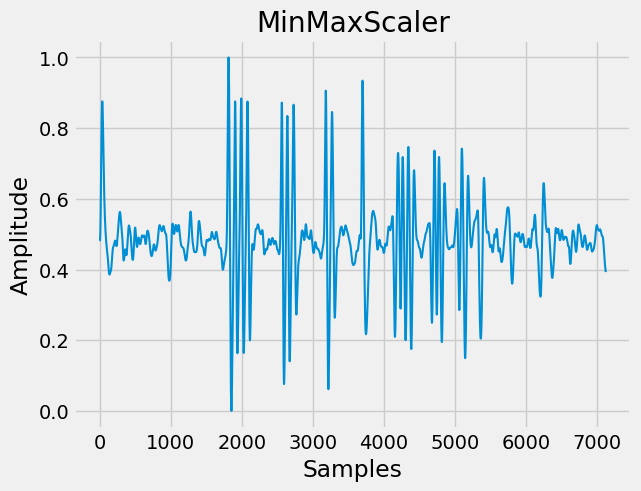

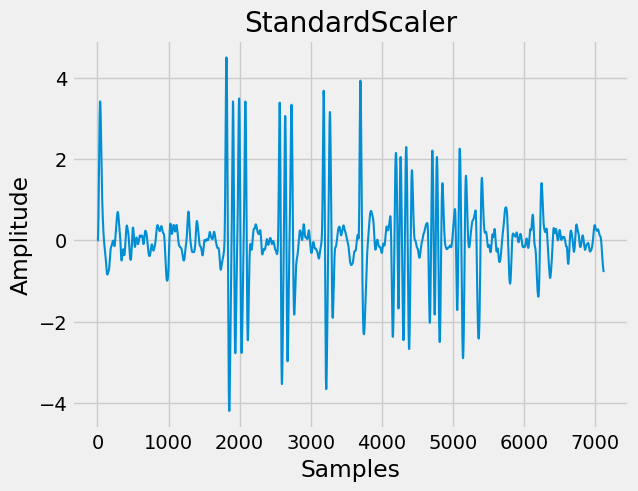

In [14]:
sc = MinMaxScaler()
data_scaler_np = np.array(data_after_band_pass_filter.iloc[0])
data_scaler_reshape = data_scaler_np.reshape(-1, 1)
data_scaler = sc.fit_transform(data_scaler_reshape)
plt.plot(data_scaler)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('MinMaxScaler')
plt.show()

scaler = StandardScaler()
standardized_data = scaler.fit_transform(data_scaler)
plt.plot(standardized_data)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('StandardScaler')
plt.show()



## Machine Learning
This course is not about ML, in the future we will make a separate course on ML, here we will briefly touch on this topic.

## Autoregression model to remove artefacts
The basic idea behind using an autoregression model for artifact removal is to model the EEG data and identify components that are likely to be related to muscle artifacts. The autoregression model represents the current value of the EEG signal as a linear combination of its past values, allowing it to capture the temporal dependencies present in the data. By doing so, it can help distinguish between genuine brain activity and muscle artifacts.

**Positive**

*   Temporal Patterns: Muscle artifacts often exhibit distinct temporal patterns, such as rhythmic or repetitive activity. AR models are capable of capturing such temporal dependencies by modeling the relationship between current EEG samples and their past values.

* Signal Prediction: AR models predict future values based on previous observations. By training an AR model on "clean" EEG data, it can learn the typical EEG patterns. When applied to contaminated data, it can identify deviations from these learned patterns, which are likely caused by muscle artifacts.

* Adaptability: AR models can adapt to variations in muscle artifacts over time. Since muscle artifacts can change in intensity, frequency, and duration, the dynamic nature of AR models allows them to adjust to these changes.

* Non-Stationarity: EEG signals are often non-stationary due to changing brain activity and external influences. AR models can handle non-stationarity by updating their coefficients as new data points arrive, helping to track and remove muscle artifacts effectively.

* Feature Extraction: AR models estimate coefficients that represent the relationship between the current EEG sample and past values. These coefficients can serve as features for identifying and characterizing muscle artifacts, enabling their removal.

* Adaptive Filtering: AR models can be adapted into adaptive filters that continuously update their parameters to minimize the difference between observed EEG data and the predicted values. This adaptation helps track and reduce the impact of muscle artifacts in real-time.

**Negative**  
*   Complex Artifact Patterns: Muscle artifacts in EEG data can exhibit complex and non-linear patterns that may not be effectively captured by linear AR models. This can result in incomplete or inaccurate removal of artifacts.

* Limited Temporal Range: AR models rely on past EEG samples to predict future values. However, muscle artifacts can have extended temporal effects that go beyond the range considered by the model, leading to inadequate artifact removal.

* Adaptability: AR models might struggle to adapt to the changing characteristics of muscle artifacts over time, particularly when artifacts vary in intensity, frequency, and duration.

* Coexisting Signals: EEG signals of interest can overlap with muscle artifacts in both time and frequency domains. AR models might mistakenly remove genuine neural activity along with artifacts, leading to loss of important brain signal information.

* Limited Frequency Specificity: Muscle artifacts can span a wide frequency range, and AR models might not accurately separate the artifact frequencies from genuine neural oscillations.

* Non-Linear Relationships: Muscle artifacts can have non-linear relationships with EEG signals. AR models, being linear in nature, might not adequately address these complex interactions.

**How it works**  
Autoregressive (AR) models for EEG artifact removal work by predicting the current EEG sample using its past values. The model is trained on clean EEG data to learn the relationship between past and present samples. When applied to contaminated EEG data with muscle artifacts, the model detects deviations from the learned patterns and estimates the artifact components. These estimated artifacts are then subtracted from the original data, aiming to retain genuine neural activity while reducing the influence of muscle artifacts. However, AR models might struggle with complex artifact patterns, temporal range limitations, and non-linear relationships, potentially leading to incomplete artifact removal.  




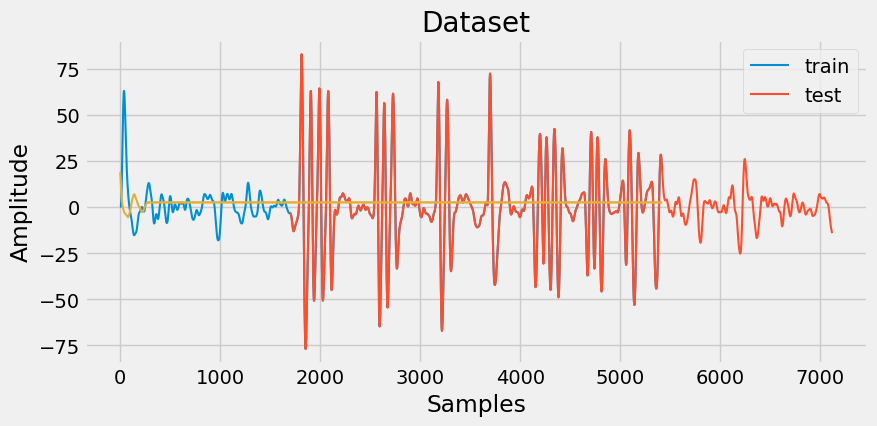

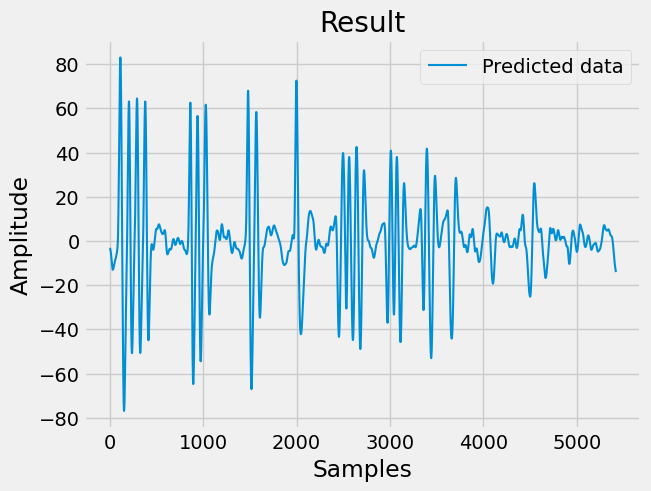

In [15]:
#!pip install skforecast
#!pip install tensorflow_addons

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg


data = data_after_band_pass_filter.iloc[0]
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5

steps = 1700
data_train = data[:-steps]
data_test  = data[steps:]

data_train = pd.DataFrame(data_train)
data_test = pd.DataFrame(data_test)

data_train["y"] =  data_train
data_test ["y"]  = data_test

fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags = 6 )
forecaster.fit(y=data_train["y"])
forecaster

steps = len(data_test ["y"])
predictions = forecaster.predict(steps=steps)


plt.plot(list(predictions))
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Dataset')
plt.show()

plt.plot(list(data_test ["y"]))
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Result')
plt.legend(["Predicted data","Real data"])
plt.show()





## K-Nearest Neighbors (KNN)
Using KNN for detecting muscle artifacts in EEG data is an interesting approach, but it might not be the most common or straightforward method for this particular task. KNN is a simple and popular classification algorithm used for various tasks in machine learning, but it's not specifically designed for artifact detection in EEG signals.

**Positive**

*   Pattern Recognition: KNN excels at identifying patterns within data by examining the similarity between data points. It can learn from labeled examples of EEG data containing muscle artifacts and then identify similar patterns in new, unlabeled data.

* Local Behavior: KNN's classification decision is based on the class of the nearest neighbors. In the context of EEG, this means that KNN can focus on local patterns and adapt to variations in muscle artifact characteristics.

* Non-Linearity: Muscle artifacts might exhibit non-linear patterns that KNN can capture, as it doesn't make strong assumptions about the underlying data distribution.

* Adaptability: KNN can adapt to different EEG data characteristics, including varying amplitudes, frequencies, and durations of muscle artifacts, making it suitable for handling the diversity of artifact patterns.

* Feature Independence: KNN's performance is not highly affected by feature independence, which is beneficial when EEG channels can exhibit varying levels of muscle artifact contamination.

* Insensitivity to Outliers: KNN can be robust against individual noisy data points, which can be useful when dealing with noisy EEG recordings.

* Multichannel EEG: KNN can accommodate multichannel EEG data, considering the spatial relationships between different electrode recordings and capturing the artifact's presence across channels.

* Simple Implementation: KNN is relatively straightforward to implement, making it accessible for researchers without advanced programming skills.

* Interpretability: KNN's classification is based on the majority class of the k-nearest neighbors. This simplicity can provide insights into how and why certain EEG segments are classified as containing muscle artifacts.

**Negative**

*   Parameter Choice: KNN's performance can be influenced by the choice of the number of neighbors (k) and the distance metric. Optimal parameters might vary based on the EEG data characteristics and the nature of the muscle artifacts.

*  Curse of Dimensionality: KNN's effectiveness can decrease as the dimensionality of the EEG data increases. Feature selection or dimensionality reduction might be necessary to improve its performance.

*  Imbalanced Data: If the number of artifact-free EEG segments significantly outweighs the number of segments with muscle artifacts, class imbalance might affect the model's accuracy. Techniques like oversampling or weighted classes can help address this.

**How it works**  
K-Nearest Neighbors (KNN) works by identifying patterns in EEG data. Given a new EEG segment, KNN searches for the k-nearest similar segments in a training dataset containing labeled examples of muscle artifacts and artifact-free EEG. The class (muscle artifact or artifact-free) of the majority of these nearest neighbors determines the classification of the new segment.


Initialization complete
Iteration 0, inertia 1418834.1767476927
Converged at iteration 0: center shift 12.817624700261538 within tolerance 337887.1494801338.
Initialization complete
Iteration 0, inertia 1966860.5399024296
Converged at iteration 0: center shift 162.74232653578127 within tolerance 337887.1494801338.
Initialization complete
Iteration 0, inertia 2144101.9483802062
Converged at iteration 0: center shift 197.08950146241756 within tolerance 337887.1494801338.
Initialization complete
Iteration 0, inertia 1404765.7062334067
Converged at iteration 0: center shift 5.837062099795462 within tolerance 337887.1494801338.
Initialization complete
Iteration 0, inertia 1394120.8788284126
Converged at iteration 0: center shift 0.4868872535103211 within tolerance 337887.1494801338.
Initialization complete
Iteration 0, inertia 1489919.7887404105
Converged at iteration 0: center shift 28.752957826632613 within tolerance 337887.1494801338.
Initialization complete
Iteration 0, inertia 1451137.

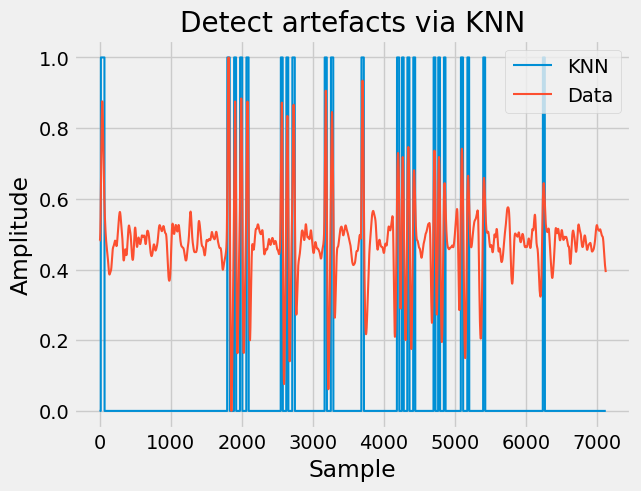

In [16]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=3, tol=1000.001, verbose=10, random_state=1, n_init=10,  copy_x=True, algorithm='elkan')
data_numpy = np.array(data_after_band_pass_filter.iloc[0])
data_reshape = data_numpy.reshape(-1,1)
kmeans.fit(data_reshape)

y_kmeans = kmeans.predict(data_reshape)

plt.plot(y_kmeans)
plt.plot(data_scaler)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Detect artefacts via KNN')
plt.legend(["KNN","Data"])
plt.show()


### K-Nearest Neighbors without library
In certain applications, particularly those involving real-time tasks, the execution time of a task holds paramount importance. Consequently, understanding the implementation of methods without relying on external libraries can prove to be invaluable. Such knowledge ultimately empowers you to optimize program execution time and achieve notable speed enhancements.Here we demonstrate how to Empirical Mode Decomposition (EMD) to remove muscle artefacts without library

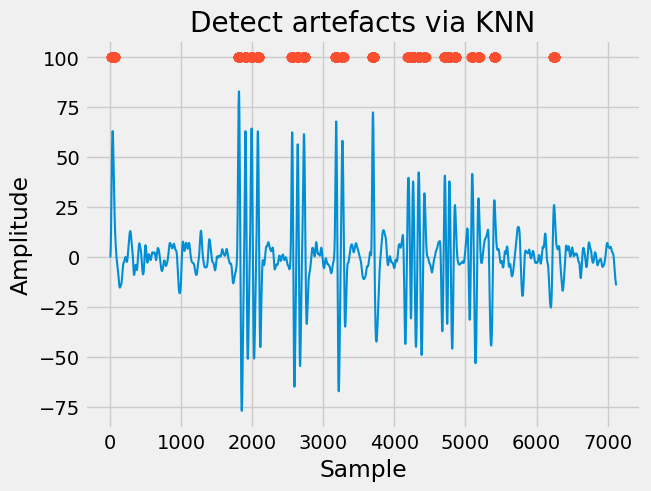

In [17]:
from scipy import signal

data = data_after_band_pass_filter.iloc[0]
data_positive = (data[data >= 0])
data_negative = (data[data <= 0])
data_positive_average = sum(data_positive) / len(data_positive)
data_negative_average = sum(data_negative) / len(data_negative)

percent = 150
amplitede_high = (data_positive_average * percent)/ 100
amplitede_low =  (data_negative_average * percent)/ 100

count_label = 0
label_artefact_positiv = []
for a in data:
    count_label = count_label + 1
    if a >= amplitede_high:
        label_artefact_positiv.append(count_label)

plt.plot(data)
y_axe = [100]* len(label_artefact_positiv)
plt.plot(label_artefact_positiv, y_axe,'o')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Detect artefacts via KNN')
plt.show()